In [1]:
import subprocess
import geojson
import firedrake
import icepack
import numpy as np
import math
import rasterio
import icepack.plot
from firedrake import assemble, Constant, inner, grad, dx, sym, sqrt, tr, ds
import matplotlib.pyplot as plt
import pickle
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)
from rasterio.plot import show
import geojson
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import pandas as pd
from rasterio.crs import CRS
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### Load extraction locations

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_2020 = extraction_locations["w_n_x_2020"]
w_n_y_2020 = extraction_locations["w_n_y_2020"]
w_s_x_2020 = extraction_locations["w_s_x_2020"]
w_s_y_2020 = extraction_locations["w_s_y_2020"]
e_n_x_2020 = extraction_locations["e_n_x_2020"]
e_n_y_2020 = extraction_locations["e_n_y_2020"]
e_s_x_2020 = extraction_locations["e_s_x_2020"]
e_s_y_2020 = extraction_locations["e_s_y_2020"]


with open("/home/sermilik/brunt_model/output_for_plotting.pkl", "rb") as f2:
    for_plotting = pickle.load(f2)
    
f2.close()

xmin = for_plotting["xmin"]
xmax = for_plotting["xmax"]
ymin = for_plotting["ymin"]
ymax = for_plotting["ymax"]
xmin_ew = for_plotting["xmin_ew"]
xmax_ew = for_plotting["xmax_ew"]
ymin_ew = for_plotting["ymin_ew"]
ymax_ew = for_plotting["ymax_ew"]
xcen_w = for_plotting["xcen_w"]
ycen_w = for_plotting["ycen_w"]
xcen_e = for_plotting["xcen_e"]
ycen_e = for_plotting["ycen_e"]
delta = for_plotting["delta"]
easting_w_n = for_plotting["easting_w_n"]
northing_w_n = for_plotting["northing_w_n"]
easting_w_s = for_plotting["easting_w_s"]
northing_w_s = for_plotting["northing_w_s"]
easting_e_n = for_plotting["easting_e_n"]
northing_e_n = for_plotting["northing_e_n"]
easting_e_s = for_plotting["easting_e_s"]
northing_e_s = for_plotting["northing_e_s"]

extent = (xmin, xmax, ymin, ymax)


### Geometry

In [3]:
outline_2020 = '/home/sermilik/brunt_model/d01_pre_calving/brunt_HC_2020.geojson'
#Brunt_SWIT_HC_2020_cutoff_r.geojson'
#brunt_HC_2020.geojson'

with open(outline_2020,"r") as outline_file_2020:
    outline_2020 = geojson.load(outline_file_2020)
    
print(outline_2020["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


### Imagery

In [4]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

### Meshing

In [5]:
geometry_2020 = icepack.meshing.collection_to_geo(outline_2020)

with open("brunt_2020.geo", "w") as geo_file_2020:
    geo_file_2020.write(geometry_2020.get_code())
    
!gmsh -2 -format msh2 -v 2 -o brunt_2020.msh brunt_2020.geo

mesh_2020 = firedrake.Mesh("brunt_2020.msh")

### Input data - thickness

In [6]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q_2020 = firedrake.FunctionSpace(mesh_2020, "CG", 2)
h0_2020 = icepack.interpolate(thickness, Q_2020)

In [7]:
#smooth the DEM

h_2020 = h0_2020.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J_2020 = 0.5 * (h_2020 - h0_2020)**2 * dx + 0.5 * α**2 * inner(grad(h_2020), grad(h_2020)) * dx
F_2020 = firedrake.derivative(J_2020, h_2020)
firedrake.solve(F_2020 == 0, h_2020)

### Input data - velocity/velocity error

In [8]:
# SNAP velocity
velocity_filename_vx_2020 = '/home/sermilik/brunt_model/d01_pre_calving/Velocity_ps_20200228_20200311_vx_filt15.tif'
velocity_filename_vy_2020 = '/home/sermilik/brunt_model/d01_pre_calving/Velocity_ps_20200228_20200311_vy_filt15.tif'

vx_2020 = rasterio.open(velocity_filename_vx_2020, "r")
vy_2020 = rasterio.open(velocity_filename_vy_2020, "r")

V_2020 = firedrake.VectorFunctionSpace(mesh_2020, "CG", 2)
u0_2020 = icepack.interpolate((vx_2020,vy_2020), V_2020)

In [9]:
velocity_filename_vx_2020_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'
velocity_filename_vy_2020_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'

stdx_2020 = rasterio.open(velocity_filename_vx_2020_err, "r")
stdy_2020 = rasterio.open(velocity_filename_vy_2020_err, "r")

σx_2020 = icepack.interpolate(stdx_2020, Q_2020)
σy_2020 = icepack.interpolate(stdy_2020, Q_2020)

### Plot inputs

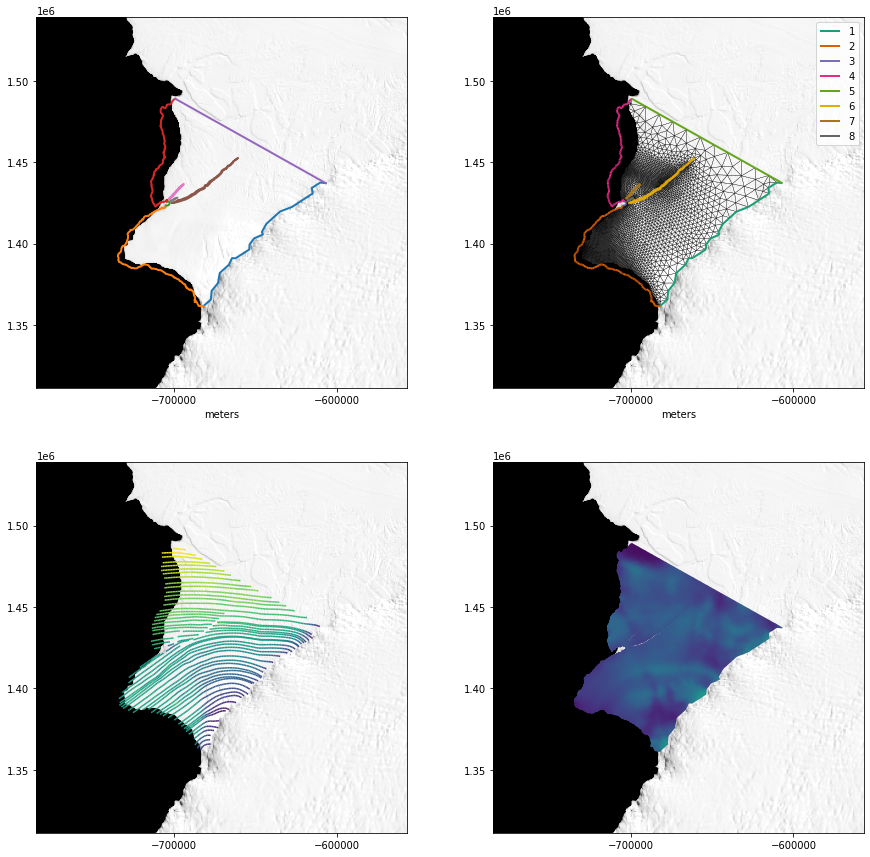

In [10]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

#OUTLINE
axes[0,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
for feature in outline_2020["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0,0].plot(xs[:, 0], xs[:, 1], linewidth=2)
axes[0,0].locator_params(axis='x',nbins=4)
axes[0,0].set_xlabel("meters");

#MESH
axes[0,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0,1].set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh_2020, axes=axes[0,1], **kwargs)
axes[0,1].locator_params(axis='x',nbins=4)
axes[0,1].legend();

#VELOCITY STREAMLINE
axes[1,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
streamlines = icepack.plot.streamplot(
    u0_2020, precision=1000, density=2000, axes=axes[1,0]
)
axes[1,0].locator_params(axis='x',nbins=4)
#fig.colorbar(streamlines, label="meters/year");

#THICKNESS RASTER
axes[1,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(h_2020, vmin=0, vmax=500, axes=axes[1,1])
axes[1,1].locator_params(axis='x',nbins=4)
#fig.colorbar(colors, label="thickness");

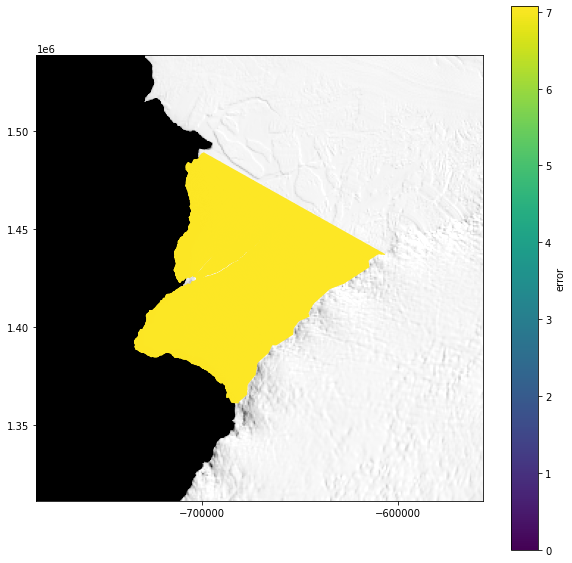

In [11]:
σ_2020 = firedrake.interpolate(firedrake.sqrt(σx_2020**2 + σy_2020**2), Q_2020)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(σ_2020, vmin=0, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors, label="error");

In [12]:
T = Constant(253)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q_2020)
u = solver.diagnostic_solve(
    velocity=u0_2020,
    thickness=h_2020,
    log_fluidity=θ,
)

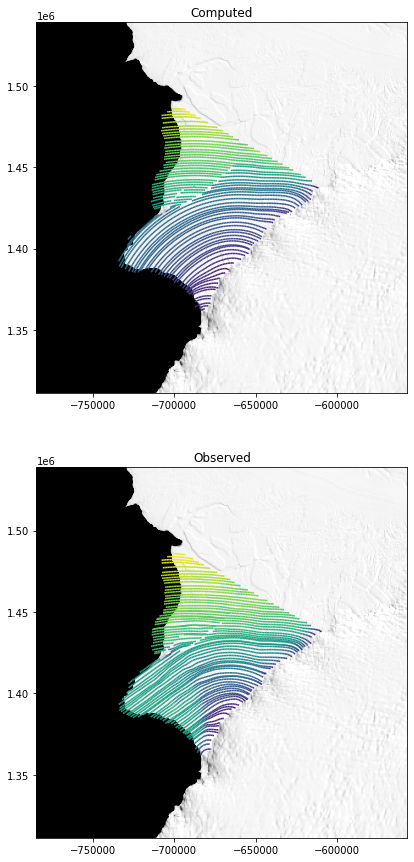

In [13]:
#fig, axes = subplots(ncols=2, sharex=True, sharey=True)
#for ax in axes:
#    ax.get_xaxis().set_visible(False)
#kwargs = {"precision": 1000, "density": 2500, "vmin": 0, "vmax": 750}
#axes[0].set_title("Computed")
#axes[1].set_title("Observed")
#icepack.plot.streamplot(u, axes=axes[0], **kwargs)
#icepack.plot.streamplot(u_obs, axes=axes[1], **kwargs);


fig, axes = plt.subplots(2,1, figsize=(7.5,15))
kwargs = {"precision": 1000, "density": 1500}
axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0].set_title("Computed")
axes[1].set_title("Observed")
icepack.plot.streamplot(u, axes=axes[0], **kwargs)
icepack.plot.streamplot(u0_2020, axes=axes[1], **kwargs);




### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [14]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0_2020,
        thickness=h_2020,
        log_fluidity=θ,
    )

In [15]:
area = Constant(assemble(Constant(1.0) * dx(mesh_2020)))

In [16]:
def loss_functional(u):
    δu = u - u0_2020
    return 0.5 / area * ((δu[0] / σx_2020)**2 + (δu[1] / σy_2020)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

In [17]:
problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

In [18]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-2,
    max_iterations=500,
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.174775e+03   2.060139e-02                  2.360691e+01   
  1     1.174289e+03   2.059246e-02   2.360691e+01   5.901726e+01   3         2         0         4         3         
  2     1.173074e+03   2.057155e-02   5.901726e+01   1.475432e+02   4         3         0         1         3         
  3     1.170042e+03   2.052352e-02   1.475432e+02   3.688579e+02   5         4         0         1         3         
  4     1.162493e+03   2.042749e-02   3.688579e+02   9.221448e+02   6         5         0         1         3         
  5     1.143760e+03   2.027485e-02   9.221448e+02   2.305362e+03   7         6         0         1         3         
  6     1.097837e+03   1.977546e-02   2.305362e+03   5.763405e+03   8         7         0         1         2         
  7     9.891818e+02   1.970913e-02   5.763405e+03   1.440851e+0

  68    7.692534e+01   5.679163e-03   1.958477e+04   1.958477e+04   70        64        0         15        3         
  69    7.692534e+01   5.679163e-03   1.958477e+04   4.896194e+03   71        64        2         7         2         
  70    6.990286e+01   5.663612e-03   4.896194e+03   4.896194e+03   72        65        0         5         3         
  71    6.696318e+01   5.414772e-03   4.896194e+03   4.896194e+03   73        66        0         10        3         
  72    6.696318e+01   5.414772e-03   4.896194e+03   3.060121e+02   74        66        2         5         3         
  73    6.589011e+01   4.401098e-03   3.060121e+02   7.650303e+02   75        67        0         1         3         
  74    6.449016e+01   1.778773e-03   7.650303e+02   1.912576e+03   76        68        0         2         3         
  75    6.337291e+01   1.215707e-03   1.912576e+03   4.781439e+03   77        69        0         7         3         
  76    6.181238e+01   2.426160e-03   4.781439e+

  137   3.093328e+01   4.098409e-04   1.741567e+03   1.245738e+20   139       128       0         20        1         
  138   3.089935e+01   1.173491e-04   6.502378e+02   3.114344e+20   140       129       0         20        1         
  139   3.086650e+01   3.971724e-04   1.682947e+03   7.785860e+20   141       130       0         20        1         
  140   3.083469e+01   1.139955e-04   6.302640e+02   1.946465e+21   142       131       0         20        1         
  141   3.080383e+01   3.849153e-04   1.630356e+03   4.866163e+21   143       132       0         20        1         
  142   3.077387e+01   1.109118e-04   6.121428e+02   1.216541e+22   144       133       0         20        1         
  143   3.074476e+01   3.736798e-04   1.582657e+03   3.041352e+22   145       134       0         20        1         
  144   3.071647e+01   1.078966e-04   5.952641e+02   7.603379e+22   146       135       0         20        1         
  145   3.068895e+01   3.637084e-04   1.538599e+

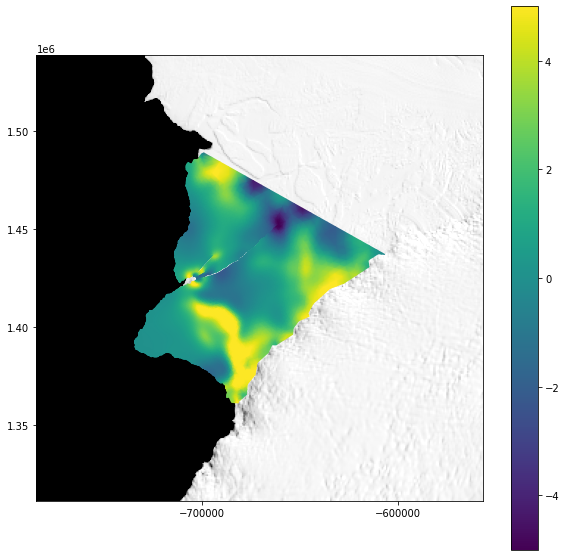

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [20]:
u_2020 = simulation(θ)

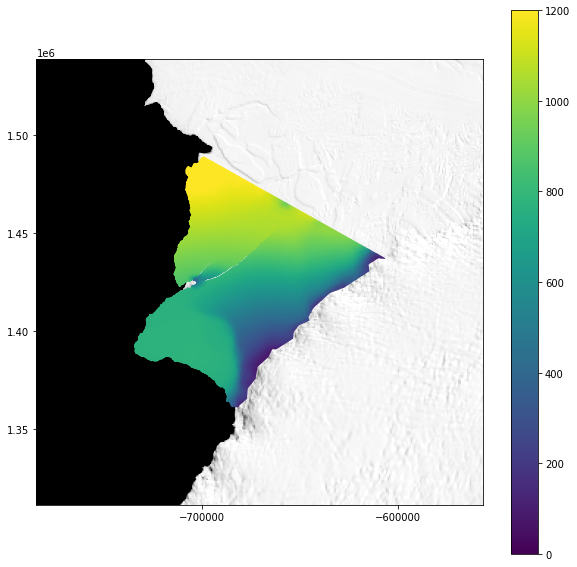

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2020, vmin=0, vmax=1200, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [22]:
visc_temp = viscosity(velocity=u_2020,thickness=h_2020,log_fluidity=θ)
visc = firedrake.project(visc_temp, Q_2020)

fluidA = A0 * firedrake.exp(θ)
fluidityA = firedrake.project(fluidA, Q_2020)

#TFS_2020 = firedrake.TensorFunctionSpace(mesh_2020, "DG", 1)
#ε = firedrake.project(sym(grad(u_2020)), TFS_2020)
#ε_e = firedrake.project(1e3 * sqrt(inner(ε, ε) + tr(ε) ** 2), Q_2020)


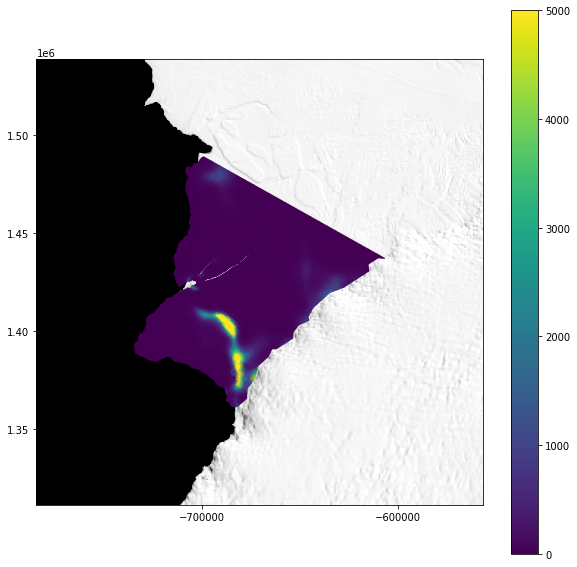

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = firedrake.tripcolor(fluidityA, vmin=0, vmax=5000, axes=ax)  
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

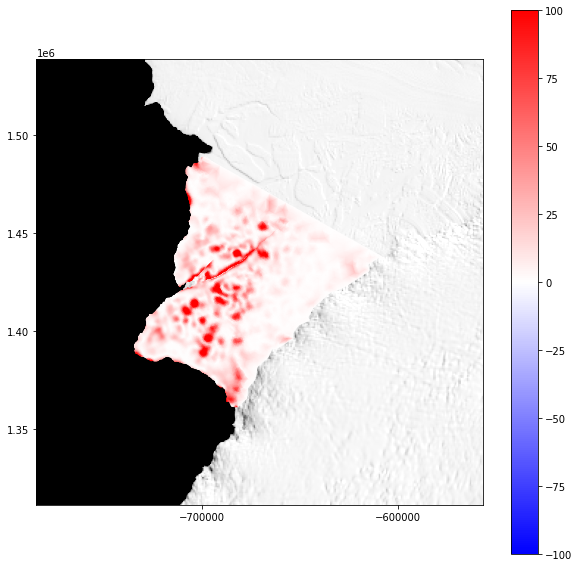

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
δu = firedrake.interpolate((u_2020 - u0_2020)**2 / (2 * σ_2020**2), Q_2020)
#δu = firedrake.interpolate((u_2020 - u0_2020) / u0_2020, Q_2020)
colors = icepack.plot.tripcolor(δu, vmin=-100, vmax=100, cmap="bwr", axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

### Grounding line flux

In [25]:
ν = firedrake.FacetNormal(mesh_2020)
influx_gl = -h_2020 * inner(u_2020, ν) * ds(1)
influx_sw = -h_2020 * inner(u_2020, ν) * ds(5)

influx_FT_gl = -h_2020 * inner(u0_2020, ν) * ds(1)
influx_FT_sw = -h_2020 * inner(u0_2020, ν) * ds(5)

print(f"Influx (grounding line): {firedrake.assemble(influx_gl) / 1e9} km^3 / year")
print(f"Influx (Stancomb-Wills): {firedrake.assemble(influx_sw) / 1e9} km^3 / year")
print("----------")
print("from FT (noisy)")
print(f"Influx FT (grounding line): {firedrake.assemble(influx_FT_gl) / 1e9} km^3 / year")
print(f"Influx FT (Stancomb-Wills): {firedrake.assemble(influx_FT_sw) / 1e9} km^3 / year")

Influx (grounding line): 3.0937879823124894 km^3 / year
Influx (Stancomb-Wills): 3.5788470400212695 km^3 / year
----------
from FT (noisy)
Influx FT (grounding line): 3.0937879823124894 km^3 / year
Influx FT (Stancomb-Wills): 3.5788470400212695 km^3 / year


### make tif

In [26]:
shelf_outline = [
( -606837.6, 1437110.4 ),( -610183.2, 1437503.2 ),( -615426.3, 1434163.1 ),( -614941.4, 1430772.5 ),( -627707.1, 1422470.6 ),( -627707.1, 1422470.6 ),( -634967.3, 1419676.9 ),( -643370.1, 1412098.9 ),( -646085.9, 1407167.4 ),( -645495.2, 1405566.9 ),( -650852.7, 1403200.7 ),( -653614.5, 1399491.6 ),( -653840.4, 1396359.7 ),( -662256.4, 1391003.6 ),( -664387.2, 1391078.8 ),( -666392.8, 1386979.7 ),( -671966.0, 1381936.3 ), ( -673018.5, 1375798.3 ),( -676963.7, 1370930.0 ),( -677400.2, 1365695.3 ),( -681830.9, 1361740.6 ),( -681770.4, 1361316.1 ),
( -681770.4, 1361316.1 ), ( -682181.4, 1361602.4 ), ( -683145.5, 1361417.3 ), ( -683477.2, 1361594.7 ), ( -683870.5, 1361517.6 ), ( -683916.8, 1361964.9 ), ( -684803.8, 1361641.0 ), ( -685251.2, 1362304.3 ), ( -686045.6, 1364039.7 ), ( -686732.0, 1364494.8 ), ( -686739.8, 1365088.7 ), ( -686870.9, 1365127.3 ), ( -687187.1, 1364093.7 ), ( -687335.1, 1364122.9 ), ( -687411.3, 1365006.4 ), ( -687398.6, 1365610.2 ), ( -687169.8, 1366373.0 ), ( -687111.8, 1366973.3 ), ( -687214.7, 1367395.7 ), ( -687447.7, 1367498.7 ), ( -687691.4, 1368208.2 ), ( -687642.6, 1368679.5 ), ( -687805.4, 1368716.0 ), ( -687906.6, 1368821.9 ), ( -687921.0, 1368990.5 ), ( -687844.0, 1369192.7 ), ( -688022.1, 1369698.3 ), ( -688075.1, 1370199.1 ), ( -688325.5, 1370666.2 ), ( -688575.9, 1370743.3 ), ( -689298.2, 1371436.7 ), ( -689272.4, 1371644.4 ), ( -689990.9, 1371812.5 ), ( -690342.5, 1371466.1 ), ( -690826.5, 1371817.6 ), ( -691025.2, 1371863.5 ), ( -691300.4, 1372199.8 ), ( -691509.3, 1372260.9 ), ( -691770.4, 1372545.4 ), ( -692007.0, 1372604.6 ), ( -692110.6, 1372893.0 ), ( -692391.6, 1372937.4 ), ( -692643.1, 1373506.9 ), ( -692938.9, 1373728.8 ), ( -692968.5, 1374261.3 ), ( -693227.4, 1374719.8 ), ( -693242.2, 1374904.7 ), ( -693464.0, 1375097.0 ), ( -693922.6, 1375185.8 ), ( -694654.8, 1375681.3 ), ( -695032.0, 1376184.3 ), ( -695321.4, 1376365.4 ), ( -695542.5, 1376625.9 ), ( -695901.8, 1376866.8 ), ( -696328.2, 1377028.6 ), ( -696576.9, 1377127.3 ), ( -696908.6, 1377597.2 ), ( -697082.3, 1377889.3 ), ( -697323.1, 1378031.4 ), ( -697789.0, 1378276.2 ), ( -698231.2, 1378398.6 ), ( -698506.4, 1378478.0 ), ( -698799.4, 1378735.7 ), ( -699046.6, 1378922.7 ), ( -699335.5, 1379043.3 ), ( -699859.1, 1379059.9 ), ( -700102.7, 1379527.7 ), ( -700289.3, 1379617.2 ), ( -700520.8, 1379691.9 ), ( -700797.0, 1380065.2 ), ( -701147.9, 1380304.1 ), ( -701625.7, 1380528.1 ), ( -701842.2, 1380640.0 ), ( -702312.5, 1380669.9 ), ( -702558.9, 1380834.2 ), ( -702850.1, 1380886.4 ), ( -703215.9, 1380893.9 ), ( -704583.5, 1381440.7 ), ( -704987.2, 1381440.7 ), ( -705325.7, 1381610.0 ), ( -705573.2, 1382078.8 ), ( -706367.5, 1382495.5 ), ( -707096.8, 1383094.5 ), ( -708021.3, 1383524.2 ), ( -708412.0, 1383745.6 ), ( -709089.2, 1383719.6 ), ( -709336.6, 1383823.8 ), ( -709987.7, 1383862.8 ), ( -710782.0, 1384305.6 ), ( -711211.8, 1384422.8 ), ( -711524.3, 1384344.6 ), ( -711829.7, 1384511.6 ), ( -712623.9, 1384702.5 ), ( -713234.9, 1384603.3 ), ( -713769.4, 1384649.1 ), ( -714105.5, 1384817.1 ), ( -714410.9, 1385305.8 ), ( -714808.0, 1385634.2 ), ( -715075.3, 1385764.0 ), ( -715525.9, 1386527.7 ), ( -716075.7, 1386825.5 ), ( -717152.5, 1387108.1 ), ( -717756.6, 1387174.4 ), ( -718704.3, 1387111.2 ), ( -719146.6, 1386795.3 ), ( -719424.5, 1386782.7 ), ( -720511.2, 1385872.9 ), ( -721294.6, 1385822.3 ), ( -722115.9, 1385430.6 ), ( -722393.9, 1385102.1 ), ( -723189.9, 1384824.1 ), ( -724402.9, 1384811.5 ), ( -724933.6, 1385038.9 ), ( -725527.5, 1385076.9 ), ( -726007.6, 1384900.0 ), ( -726984.1, 1385566.0 ), ( -727557.5, 1385636.5 ), ( -728704.5, 1386531.9 ), ( -729660.2, 1387065.1 ), ( -729921.8, 1387175.8 ), ( -730324.2, 1387095.3 ), ( -730817.2, 1387236.1 ), ( -731088.9, 1387407.2 ), ( -731551.7, 1387477.6 ), ( -732326.3, 1388051.0 ), ( -732598.0, 1388352.9 ), ( -733080.6, 1388560.2 ), ( -733751.9, 1388665.7 ), ( -733857.4, 1389154.8 ), ( -734327.3, 1390017.9 ), ( -734058.8, 1390612.5 ), ( -734135.5, 1391523.6 ), ( -734471.2, 1392041.4 ), ( -734509.6, 1392405.9 ), ( -734394.5, 1393086.8 ), ( -734080.4, 1393611.6 ), ( -733973.4, 1393937.0 ), ( -733554.3, 1394128.7 ), ( -733505.3, 1394258.0 ), ( -733135.3, 1394619.2 ), ( -732863.3, 1394859.9 ), ( -732661.0, 1395056.7 ), ( -732559.2, 1395404.6 ), ( -732381.1, 1395803.3 ), ( -732372.6, 1396210.5 ), ( -732423.5, 1396677.2 ), ( -732287.7, 1397050.5 ), ( -732236.8, 1397296.5 ), ( -732084.1, 1397559.5 ), ( -732075.6, 1397754.6 ), ( -731626.0, 1398017.6 ), ( -731609.0, 1398509.7 ), ( -731562.2, 1398644.6 ), ( -731220.4, 1398660.7 ), ( -730907.7, 1398747.7 ), ( -730649.7, 1398799.3 ), ( -730391.7, 1398947.7 ), ( -730272.4, 1398973.5 ), ( -729828.8, 1399329.6 ), ( -729781.0, 1399831.8 ), ( -729677.3, 1400055.0 ), ( -729470.1, 1400230.4 ), ( -729254.8, 1400740.6 ), ( -728959.9, 1401123.2 ), ( -728856.2, 1401960.3 ), ( -728424.2, 1402858.9 ), ( -728269.7, 1403640.7 ), ( -728260.6, 1405031.4 ), ( -728542.4, 1405640.4 ), ( -728496.9, 1406004.0 ), ( -728215.2, 1406513.0 ), ( -728024.3, 1406913.0 ), ( -727329.0, 1407332.5 ), ( -726855.0, 1407921.8 ), ( -726778.1, 1408383.0 ), ( -726637.2, 1408523.9 ), ( -726265.7, 1408370.1 ), ( -725778.9, 1408447.0 ), ( -725343.4, 1408523.9 ), ( -724831.0, 1408959.4 ), ( -724152.1, 1409664.0 ), ( -723665.3, 1409984.2 ), ( -723383.5, 1410509.4 ), ( -722704.5, 1411265.2 ), ( -722076.3, 1411877.7 ), ( -721764.9, 1412068.3 ), ( -721409.1, 1412532.2 ), ( -721250.2, 1413116.8 ), ( -720996.1, 1413606.0 ), ( -720456.0, 1413618.7 ), ( -719992.1, 1413961.9 ), ( -719795.1, 1414807.0 ), ( -718944.3, 1414727.4 ), ( -718790.3, 1415343.2 ), ( -718251.5, 1416513.3 ), ( -717589.4, 1416836.7 ), ( -716049.8, 1416929.0 ), ( -715972.8, 1417206.2 ), ( -715295.4, 1417313.9 ), ( -714664.1, 1418083.8 ), ( -714094.5, 1418176.1 ), ( -713678.7, 1418330.1 ), ( -713724.9, 1418684.2 ), ( -712539.4, 1419346.3 ), ( -711867.0, 1419860.3 ), ( -711466.1, 1419993.9 ), ( -710904.8, 1420181.0 ), ( -710523.9, 1420448.3 ), ( -710490.5, 1420588.6 ), ( -709555.0, 1420876.0 ), ( -708786.6, 1421063.1 ), ( -708532.7, 1421497.4 ), ( -707663.7, 1421490.0 ), ( -707460.0, 1422101.2 ), ( -706741.5, 1421843.8 ), ( -706087.3, 1421918.9 ), ( -705293.8, 1422229.9 ), ( -705304.5, 1423012.7 ), ( -704866.5, 1423373.0 ),    
( -704866.5, 1423373.0 ), ( -704464.1, 1423373.4 ), ( -704260.1, 1423364.9 ), ( -703979.6, 1423398.9 ), ( -703682.0, 1423517.9 ), ( -703446.2, 1423675.2 ), ( -703240.0, 1423823.9 ), ( -703078.5, 1424002.5 ), ( -702877.0, 1424290.1 ), ( -702763.9, 1424606.0 ), ( -702755.4, 1424988.6 ), ( -702823.4, 1425252.1 ), ( -703293.3, 1425747.4 ), ( -703703.6, 1425904.1 ), ( -704091.4, 1425911.5 ), ( -704464.3, 1425814.6 ),    
( -704464.3, 1425814.6 ), ( -704514.0, 1426274.4 ), ( -704186.7, 1426478.1 ), ( -704048.5, 1426921.7 ), ( -704783.2, 1426674.4 ), ( -705241.4, 1426143.5 ), ( -705634.1, 1425867.1 ), ( -706026.9, 1425728.9 ), ( -706595.2, 1425428.5 ), ( -706911.9, 1425704.9 ), ( -707857.3, 1425535.7 ), ( -707917.1, 1425185.5 ), ( -708216.0, 1424972.0 ), ( -708506.4, 1425262.4 ), ( -709001.8, 1425048.8 ), ( -709172.6, 1424519.3 ), ( -709411.7, 1424246.0 ), ( -709676.5, 1423981.2 ), ( -710095.0, 1424160.6 ), ( -710462.3, 1423904.3 ), ( -710855.2, 1423520.0 ), ( -711008.9, 1423178.4 ), ( -711538.5, 1422708.6 ), ( -711683.7, 1423144.2 ), ( -711939.9, 1423554.2 ), ( -712213.2, 1423972.7 ), ( -712203.9, 1424343.2 ), ( -712318.3, 1424438.5 ), ( -712561.5, 1424543.4 ), ( -712971.5, 1425148.9 ), ( -713009.6, 1425797.3 ), ( -713085.9, 1425959.4 ), ( -713367.2, 1426264.5 ), ( -713409.8, 1426698.5 ), ( -713547.4, 1426912.6 ), ( -713581.9, 1427348.4 ), ( -713547.4, 1427673.4 ), ( -713704.2, 1427941.0 ), ( -713704.1, 1428379.8 ), ( -713843.4, 1428426.2 ), ( -714075.6, 1428565.5 ), ( -714160.0, 1428899.0 ), ( -714265.5, 1429038.3 ), ( -714290.9, 1429287.4 ), ( -714214.9, 1429460.5 ), ( -714050.2, 1429903.7 ), ( -713684.3, 1430961.2 ), ( -713374.2, 1431638.8 ), ( -713201.9, 1432385.3 ), ( -713213.4, 1433028.4 ), ( -713466.1, 1433373.0 ), ( -713374.2, 1433832.4 ), ( -713741.7, 1434647.8 ), ( -713753.2, 1435290.9 ), ( -713802.3, 1435450.7 ), ( -714007.5, 1435695.1 ), ( -713895.1, 1435905.2 ), ( -713870.7, 1436056.7 ), ( -713768.1, 1436213.1 ), ( -713880.7, 1436550.2 ), ( -713984.0, 1437309.4 ), ( -714020.4, 1437868.2 ), ( -714117.6, 1438111.2 ), ( -714002.2, 1438512.0 ), ( -713892.7, 1438826.8 ), ( -713614.0, 1439158.6 ), ( -713560.9, 1439364.4 ), ( -713348.5, 1439590.0 ), ( -713182.6, 1439988.2 ), ( -712864.1, 1440187.3 ), ( -712837.5, 1440572.2 ), ( -712658.3, 1441189.4 ), ( -712605.2, 1441793.3 ), ( -712572.1, 1442237.9 ), ( -712392.9, 1442317.6 ), ( -712154.0, 1442317.6 ), ( -712134.1, 1442675.9 ), ( -712266.0, 1443100.8 ), ( -712149.2, 1444044.3 ), ( -711610.1, 1444394.7 ), ( -711601.1, 1444538.5 ), ( -711259.6, 1444924.8 ), ( -711124.9, 1445580.8 ), ( -710810.4, 1445598.7 ), ( -710657.6, 1445904.2 ), ( -710397.0, 1445994.1 ), ( -710019.6, 1446066.0 ), ( -709705.2, 1446443.4 ), ( -709471.5, 1446497.3 ), ( -709304.7, 1446833.6 ), ( -709304.7, 1447215.6 ), ( -709133.5, 1447373.6 ), ( -709140.1, 1447689.8 ), ( -708744.9, 1447973.0 ), ( -708580.2, 1448196.9 ), ( -708112.6, 1448354.9 ), ( -707631.9, 1448657.9 ), ( -707414.5, 1448987.2 ), ( -707065.5, 1449316.5 ), ( -706853.0, 1449749.6 ), ( -706745.2, 1450216.8 ), ( -706781.1, 1450675.0 ), ( -706844.0, 1451043.4 ), ( -706844.0, 1451330.9 ), ( -706610.4, 1451798.1 ), ( -706421.7, 1452040.7 ), ( -706224.1, 1452130.5 ), ( -706124.3, 1452619.7 ), ( -705951.3, 1453147.3 ), ( -705614.0, 1452939.7 ), ( -705363.2, 1452931.1 ), ( -705467.0, 1453173.3 ), ( -705864.8, 1453657.6 ), ( -706150.3, 1454375.6 ), ( -706176.2, 1454643.7 ), ( -706349.2, 1454868.6 ), ( -706245.4, 1455387.6 ), ( -706401.1, 1455638.4 ), ( -706617.4, 1455880.6 ), ( -706637.1, 1456046.3 ), ( -706345.2, 1456367.3 ), ( -706199.3, 1456608.1 ), ( -705827.2, 1456907.3 ), ( -705768.8, 1457184.5 ), ( -705929.4, 1457636.9 ), ( -705900.2, 1458125.8 ), ( -705739.7, 1458315.5 ), ( -705455.1, 1458359.2 ), ( -705374.8, 1458694.9 ), ( -705381.3, 1459432.9 ), ( -705407.7, 1459696.7 ), ( -705534.3, 1459891.9 ), ( -705597.6, 1460340.3 ), ( -705951.0, 1460915.3 ), ( -706077.7, 1461522.0 ), ( -706172.6, 1461696.1 ), ( -706109.3, 1461843.8 ), ( -705914.1, 1462075.9 ), ( -705683.0, 1462745.8 ), ( -705722.5, 1463318.6 ), ( -706058.3, 1463713.7 ), ( -705979.3, 1464661.8 ), ( -706295.3, 1465353.2 ), ( -706275.6, 1466084.0 ), ( -706571.8, 1466834.6 ), ( -706986.7, 1467446.9 ), ( -706927.4, 1468237.1 ), ( -707164.4, 1468948.1 ), ( -707243.4, 1469698.7 ), ( -707618.7, 1470172.8 ), ( -707836.0, 1471140.7 ), ( -708152.1, 1471871.5 ), ( -708468.1, 1472108.6 ), ( -708132.3, 1472878.9 ), ( -708148.0, 1473887.5 ), ( -707992.3, 1475150.5 ), ( -707975.0, 1476102.0 ), ( -707455.9, 1476724.9 ), ( -707248.3, 1477659.2 ), ( -706833.1, 1478160.9 ), ( -706971.5, 1479043.3 ), ( -707231.0, 1479493.1 ), ( -707577.0, 1479683.5 ), ( -707646.2, 1480012.2 ), ( -708182.6, 1480444.7 ), ( -708256.3, 1482248.2 ), ( -707908.3, 1483070.7 ), ( -707243.9, 1483909.1 ), ( -706832.7, 1483924.9 ), ( -706421.4, 1483450.4 ), ( -705314.1, 1483213.1 ), ( -704997.7, 1483830.0 ), ( -704507.4, 1484589.3 ), ( -704412.5, 1485237.8 ), ( -703542.5, 1485522.5 ), ( -702814.8, 1485411.8 ), ( -701681.8, 1485937.0 ), ( -701180.3, 1487220.7 ), ( -700077.1, 1488504.4 ), ( -699154.4, 1488905.6 ),    
( -699154.4, 1488905.6 ), ( -606837.6, 1437110.4 )    
]

shelf_poly = Polygon(shelf_outline)


rift_outline = [
( -701348.0, 1425006.8 ), ( -700115.7, 1425318.3 ), ( -699100.0, 1425873.5 ), ( -698544.8, 1426076.6 ), ( -697948.9, 1426510.0 ), ( -697041.6, 1426916.2 ), ( -696567.7, 1426686.0 ), ( -695646.8, 1427038.1 ), ( -692951.9, 1428162.1 ), ( -692721.7, 1428067.3 ), ( -690893.5, 1429110.1 ), ( -690171.3, 1429516.6 ), ( -689897.5, 1429868.6 ), ( -689095.7, 1430308.6 ), ( -688215.7, 1430650.8 ), ( -687502.0, 1431022.4 ), ( -686592.6, 1431970.9 ), ( -684871.7, 1433046.4 ), ( -684099.3, 1433437.5 ), ( -683016.0, 1433809.7 ), ( -682522.3, 1434176.3 ), ( -681766.7, 1434475.5 ), ( -681445.0, 1434744.8 ), ( -681175.7, 1435560.2 ), ( -680928.8, 1435859.4 ), ( -680465.0, 1436016.5 ), ( -680285.5, 1435934.2 ), ( -679866.6, 1436098.8 ), ( -679215.7, 1436809.5 ), ( -678894.1, 1437310.7 ), ( -678311.4, 1437773.9 ), ( -678282.1, 1438125.6 ), ( -677827.7, 1438455.4 ), ( -677138.8, 1438689.9 ), ( -676787.1, 1439063.7 ), ( -675827.0, 1439650.0 ), ( -675380.0, 1440163.0 ), ( -674779.0, 1440426.8 ), ( -674456.6, 1440771.2 ), ( -673829.1, 1441050.2 ), ( -673597.6, 1441525.3 ), ( -672696.1, 1442110.1 ), ( -672026.0, 1442792.4 ), ( -671453.4, 1443279.7 ), ( -671063.5, 1443901.0 ), ( -670990.4, 1444412.7 ), ( -670320.4, 1445082.8 ), ( -669638.1, 1445557.9 ), ( -668931.5, 1445960.0 ), ( -668480.7, 1446008.7 ), ( -667969.0, 1446508.2 ), ( -667420.8, 1447214.8 ), ( -666787.2, 1447848.4 ), ( -666312.1, 1448043.3 ), ( -665885.7, 1448128.6 ), ( -665222.4, 1448642.0 ), ( -665045.7, 1449083.8 ), ( -664414.6, 1449456.1 ), ( -663865.5, 1450024.2 ), ( -663650.9, 1450484.9 ), ( -660764.3, 1452602.6 ), ( -660816.9, 1452456.0 ), ( -663555.7, 1450440.2 ), ( -663915.7, 1449601.8 ), ( -664226.7, 1449345.2 ), ( -664859.5, 1448838.8 ), ( -665128.0, 1448413.9 ), ( -665466.8, 1448066.8 ), ( -665795.6, 1447868.4 ), ( -666237.7, 1447777.7 ), ( -666572.2, 1447630.3 ), ( -667516.3, 1446471.9 ), ( -668040.1, 1445853.4 ), ( -668860.6, 1445506.2 ), ( -669636.7, 1445123.0 ), ( -670410.9, 1444501.1 ), ( -670419.3, 1444175.4 ), ( -670991.5, 1443189.2 ), ( -671998.4, 1442167.2 ), ( -672554.5, 1441566.0 ), ( -673336.0, 1441009.9 ), ( -673943.3, 1440472.3 ), ( -675130.6, 1439791.5 ), ( -675283.1, 1439328.6 ), ( -676628.2, 1438637.0 ), ( -676862.4, 1438195.8 ), ( -677622.5, 1437542.3 ), ( -678169.9, 1436823.9 ), ( -678956.7, 1436310.8 ), ( -678973.8, 1435780.5 ), ( -679521.2, 1435455.6 ), ( -680547.4, 1435250.3 ), ( -681043.5, 1434720.1 ), ( -681231.6, 1433899.0 ), ( -682590.1, 1433271.4 ), ( -683623.3, 1432924.6 ), ( -684430.1, 1432422.2 ), ( -685675.6, 1431615.4 ), ( -686486.1, 1430828.2 ), ( -687016.0, 1430417.0 ), ( -688277.0, 1429786.6 ), ( -689245.6, 1429156.1 ), ( -690223.4, 1428490.7 ), ( -692462.1, 1427288.6 ), ( -693446.5, 1426922.7 ), ( -694936.1, 1426461.0 ), ( -697430.4, 1425691.0 ), ( -699579.7, 1425146.1 ), ( -700926.9, 1424949.3 ), ( -701348.0, 1425006.8 )    
]

rift_poly = Polygon(rift_outline)


rift2_outline = [
( -702662.5, 1427522.1 ), ( -701464.3, 1428467.4 ), ( -700505.7, 1429266.2 ), ( -699400.7, 1430690.7 ), ( -697643.3, 1432687.7 ), ( -696365.2, 1434165.5 ), ( -695313.4, 1435150.7 ), ( -694000.1, 1436484.1 ), ( -694310.6, 1436520.6 ), ( -696209.9, 1435077.9 ), ( -697269.1, 1433982.1 ), ( -698620.6, 1432448.0 ), ( -700325.8, 1430626.5 ), ( -701071.2, 1429867.5 ), ( -701776.0, 1428837.4 ), ( -702399.4, 1428444.4 ), ( -702968.7, 1427902.3 ), ( -703131.3, 1427387.2 ), ( -702662.5, 1427522.1 )
]

rift2_poly = Polygon(rift2_outline)


rift3_outline = [
( -702222.8, 1426021.6 ), ( -701413.9, 1426608.1 ), ( -700443.1, 1427154.1 ), ( -700099.3, 1427457.5 ), ( -698811.7, 1428023.8 ), ( -698101.4, 1428231.7 ), ( -697982.3, 1428199.2 ), ( -697982.3, 1428107.2 ), ( -699746.9, 1427262.8 ), ( -700006.7, 1426959.7 ), ( -700850.9, 1426547.4 ), ( -701218.7, 1426372.5 ), ( -701402.6, 1426125.8 ), ( -701904.9, 1425950.9 ), ( -702165.1, 1425906.0 ), ( -702222.8, 1426021.6 )
]

rift3_poly = Polygon(rift3_outline)


In [27]:
tifxmin = -750000
tifxmax = -600000
tifymin = 1350000
tifymax = 1500000
tifres = 100 #250

tifxlen = (tifxmax-tifxmin)/tifres
tifylen = (tifymax-tifymin)/tifres

tifx = np.linspace(tifxmin+(tifres/2),tifxmax-(tifres/2),num=int(tifxlen))
tify = np.linspace(tifymax-(tifres/2),tifymin+(tifres/2),num=int(tifylen))


In [28]:
tras = np.zeros((int(tifxlen),int(tifylen)))
vras = np.zeros((int(tifxlen),int(tifylen)))
vxras = np.zeros((int(tifxlen),int(tifylen)))
vyras = np.zeros((int(tifxlen),int(tifylen)))
viscos = np.zeros((int(tifxlen),int(tifylen)))
fluid = np.zeros((int(tifxlen),int(tifylen)))
e_eff = np.zeros((int(tifxlen),int(tifylen)))

for tx in range(0,int(tifxlen)):
    for ty in range(0,int(tifylen)):
        on_shelf = shelf_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift = rift_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift2 = rift2_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift3 = rift3_poly.contains(Point(tifx[tx],tify[ty]))
        
        if (on_shelf==True) & (in_rift==False) & (in_rift2==False) & (in_rift3==False):
            tras[ty,tx] = θ((tifx[tx],tify[ty]))
            vras[ty,tx] = np.sqrt(u_2020((tifx[tx],tify[ty]))[0] **2 + u_2020((tifx[tx],tify[ty]))[1] **2)
            vxras[ty,tx] = u_2020((tifx[tx],tify[ty]))[0]
            vyras[ty,tx] = u_2020((tifx[tx],tify[ty]))[1]
            viscos[ty,tx] = visc((tifx[tx],tify[ty]))
            fluid[ty,tx] = fluidityA((tifx[tx],tify[ty]))
            #e_eff[ty,tx] = ε_e((tifx[tx],tify[ty]))
        else:
            tras[ty,tx] = np.nan
            vras[ty,tx] = np.nan
            vxras[ty,tx] = np.nan
            vyras[ty,tx] = np.nan
            viscos[ty,tx] = np.nan
            fluid[ty,tx] = np.nan
            #e_eff[ty,tx] = np.nan
            

In [29]:
driver = "GTiff"
dim = tras.shape
height = dim[0]
width = dim[1]
count = 1
dtype = tras.dtype

print(height,width)
print(dtype)


1500 1500
float64


In [30]:
crs = CRS.from_epsg(3031)

transform = from_origin(tifxmin,tifymax,tifres,tifres)

print(transform)

| 100.00, 0.00,-750000.00|
| 0.00,-100.00, 1500000.00|
| 0.00, 0.00, 1.00|


In [31]:
with rasterio.open("./output/fluidity_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(tras,1)

In [32]:
with rasterio.open("./output/model_velocity_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vras,1)

In [33]:
with rasterio.open("./output/model_velocity_vx_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vxras,1)

In [34]:
with rasterio.open("./output/model_velocity_vy_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vyras,1)

In [35]:
with rasterio.open("./output/model_viscosity_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(viscos,1)

In [36]:
with rasterio.open("./output/model_fluidity_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(fluid,1)

In [37]:
#with rasterio.open("./output/model_eff_strain_pre_calving_err5_T253_steptol_1Eneg2.tif",'w',
#                  driver=driver,
#                  height=height,
#                  width=width,
#                  count=count,
#                  dtype=dtype,
#                  crs=crs,
#                  transform=transform) as dst:
#    dst.write(e_eff,1)

### make fig

-----------
2.4669879388406626
22.547315252489305
-4.505755601492937
6.939990117121859
-----------
Ground track angles
western pair: -34.2 deg
western pair: -0.6 rad
eastern pair: -37.3 deg
eastern pair: -0.65 rad

western pair, seaward
v east: -792.5m/yr, v_north: -34.1 m/yr, v_total: 793.2 m/yr
angle : -92.5 deg
offset: 58.3 deg

western pair, landward
v east: -733.0m/yr, v_north: -304.3 m/yr, v_total: 793.6 m/yr
angle : -112.5 deg
offset: 78.4 deg

eastern pair, seaward
v east: -971.2m/yr, v_north: 76.5 m/yr, v_total: 974.2 m/yr
angle : -85.5 deg
offset: 48.2 deg

eastern pair, landward
v east: -896.2m/yr, v_north: -109.1 m/yr, v_total: 902.8 m/yr
angle : -96.9 deg
offset: 59.7 deg

------------------------------

west,  seaward v_total: 793.2 m/yr
west, landward v_total: 793.6 m/yr
east,  seaward v_total: 974.2 m/yr
east, landward v_total: 902.8 m/yr

west,   seaward v_perp: 416.7 m/yr
west,  landward v_perp: 159.8 m/yr
east,   seaward v_perp: 649.0 m/yr
east,  landward v_perp: 455

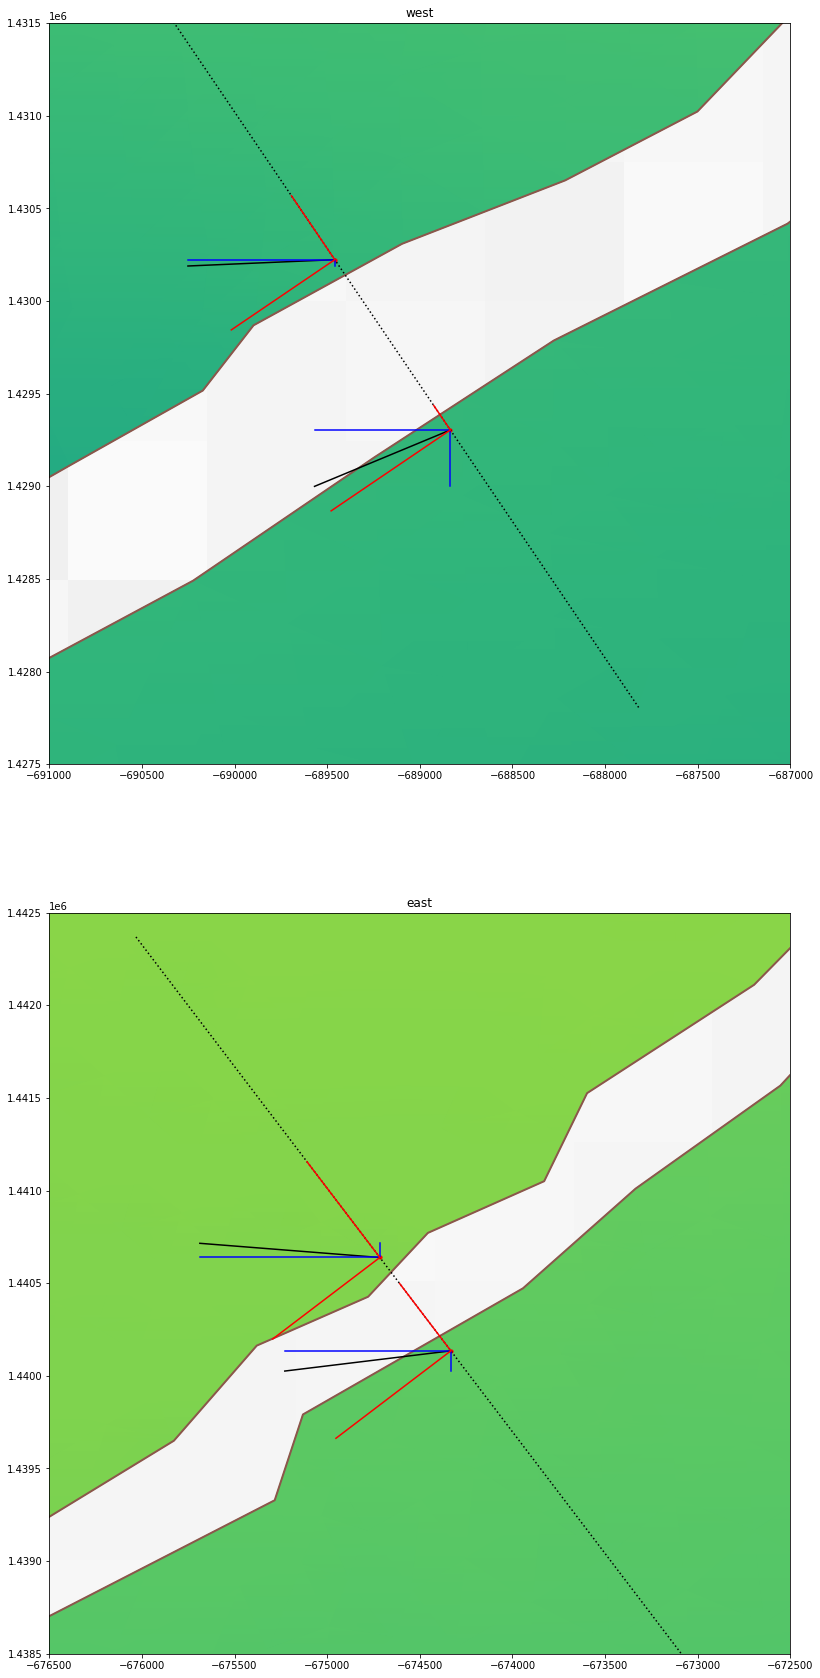

In [38]:
fig, axes = plt.subplots(2,1, figsize=(15,30))

axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2020, vmin=0, vmax=1200, axes=axes[0])

axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2020, vmin=0, vmax=1200, axes=axes[1])

for feature in outline_2020["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
for feature in outline_2020["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[1].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
axes[0].plot([easting_w_n,easting_w_s],[northing_w_n,northing_w_s],'k:')
axes[1].plot([easting_e_n,easting_e_s],[northing_e_n,northing_e_s],'k:')        
        
axes[0].scatter(w_n_x_2020,w_n_y_2020,s=10,c='r')
axes[0].scatter(w_s_x_2020,w_s_y_2020,s=10,c='r')
axes[1].scatter(e_n_x_2020,e_n_y_2020,s=10,c='r')
axes[1].scatter(e_s_x_2020,e_s_y_2020,s=10,c='r')

#model
vw_n_2020 = u_2020((w_n_x_2020,w_n_y_2020))
vw_s_2020 = u_2020((w_s_x_2020,w_s_y_2020))
ve_n_2020 = u_2020((e_n_x_2020,e_n_y_2020))
ve_s_2020 = u_2020((e_s_x_2020,e_s_y_2020))

#FT
ft_vw_n_2020 = u0_2020((w_n_x_2020,w_n_y_2020))
ft_vw_s_2020 = u0_2020((w_s_x_2020,w_s_y_2020))
ft_ve_n_2020 = u0_2020((e_n_x_2020,e_n_y_2020))
ft_ve_s_2020 = u0_2020((e_s_x_2020,e_s_y_2020))

#model
vw_n_2020_tot = np.sqrt((vw_n_2020[0]**2)+(vw_n_2020[1]**2))
vw_s_2020_tot = np.sqrt((vw_s_2020[0]**2)+(vw_s_2020[1]**2))
ve_n_2020_tot = np.sqrt((ve_n_2020[0]**2)+(ve_n_2020[1]**2))
ve_s_2020_tot = np.sqrt((ve_s_2020[0]**2)+(ve_s_2020[1]**2))

#ft
ft_vw_n_2020_tot = np.sqrt((ft_vw_n_2020[0]**2)+(ft_vw_n_2020[1]**2))
ft_vw_s_2020_tot = np.sqrt((ft_vw_s_2020[0]**2)+(ft_vw_s_2020[1]**2))
ft_ve_n_2020_tot = np.sqrt((ft_ve_n_2020[0]**2)+(ft_ve_n_2020[1]**2))
ft_ve_s_2020_tot = np.sqrt((ft_ve_s_2020[0]**2)+(ft_ve_s_2020[1]**2))

#axes.arrow(w_n_x_2020,w_n_y_2020,vw_n_2020[0],vw_n_2020[1],head_width=150,color='k')
#axes.arrow(w_s_x_2020,w_s_y_2020,vw_s_2020[0],vw_s_2020[1],head_width=150,color='k')
#axes.arrow(e_n_x_2020,e_n_y_2020,ve_n_2020[0],ve_n_2020[1],head_width=150,color='k')
#axes.arrow(e_s_x_2020,e_s_y_2020,ve_s_2020[0],ve_s_2020[1],head_width=150,color='k')

axes[0].plot([w_n_x_2020,w_n_x_2020+vw_n_2020[0]],[w_n_y_2020,w_n_y_2020+vw_n_2020[1]],color='k')
axes[0].plot([w_s_x_2020,w_s_x_2020+vw_s_2020[0]],[w_s_y_2020,w_s_y_2020+vw_s_2020[1]],color='k')
axes[1].plot([e_n_x_2020,e_n_x_2020+ve_n_2020[0]],[e_n_y_2020,e_n_y_2020+ve_n_2020[1]],color='k')
axes[1].plot([e_s_x_2020,e_s_x_2020+ve_s_2020[0]],[e_s_y_2020,e_s_y_2020+ve_s_2020[1]],color='k')

axes[0].plot([w_n_x_2020,w_n_x_2020+0],[w_n_y_2020,w_n_y_2020+vw_n_2020[1]],color='b')
axes[0].plot([w_s_x_2020,w_s_x_2020+0],[w_s_y_2020,w_s_y_2020+vw_s_2020[1]],color='b')
axes[1].plot([e_n_x_2020,e_n_x_2020+0],[e_n_y_2020,e_n_y_2020+ve_n_2020[1]],color='b')
axes[1].plot([e_s_x_2020,e_s_x_2020+0],[e_s_y_2020,e_s_y_2020+ve_s_2020[1]],color='b')

axes[0].plot([w_n_x_2020,w_n_x_2020+vw_n_2020[0]],[w_n_y_2020,w_n_y_2020+0],color='b')
axes[0].plot([w_s_x_2020,w_s_x_2020+vw_s_2020[0]],[w_s_y_2020,w_s_y_2020+0],color='b')
axes[1].plot([e_n_x_2020,e_n_x_2020+ve_n_2020[0]],[e_n_y_2020,e_n_y_2020+0],color='b')
axes[1].plot([e_s_x_2020,e_s_x_2020+ve_s_2020[0]],[e_s_y_2020,e_s_y_2020+0],color='b')

#model
vw_n_2020_angle = (math.atan(vw_n_2020[1]/vw_n_2020[0]))
vw_s_2020_angle = (math.atan(vw_s_2020[1]/vw_s_2020[0]))
ve_n_2020_angle = (math.atan(ve_n_2020[1]/ve_n_2020[0]))
ve_s_2020_angle = (math.atan(ve_s_2020[1]/ve_s_2020[0]))

#ft
ft_vw_n_2020_angle = (math.atan(ft_vw_n_2020[1]/ft_vw_n_2020[0]))
ft_vw_s_2020_angle = (math.atan(ft_vw_s_2020[1]/ft_vw_s_2020[0]))
ft_ve_n_2020_angle = (math.atan(ft_ve_n_2020[1]/ft_ve_n_2020[0]))
ft_ve_s_2020_angle = (math.atan(ft_ve_s_2020[1]/ft_ve_s_2020[0]))

print('-----------')
print(math.degrees(vw_n_2020_angle))
print(math.degrees(vw_s_2020_angle))
print(math.degrees(ve_n_2020_angle))
print(math.degrees(ve_s_2020_angle))
print('-----------')

#model
vw_n_2020_offset = abs(-90-math.degrees(vw_n_2020_angle) - math.degrees(west_angle))
vw_s_2020_offset = abs(-90-math.degrees(vw_s_2020_angle) - math.degrees(west_angle))
ve_n_2020_offset = abs(-90-math.degrees(ve_n_2020_angle) - math.degrees(east_angle))
ve_s_2020_offset = abs(-90-math.degrees(ve_s_2020_angle) - math.degrees(east_angle))

#ft
ft_vw_n_2020_offset = abs(-90-math.degrees(ft_vw_n_2020_angle) - math.degrees(west_angle))
ft_vw_s_2020_offset = abs(-90-math.degrees(ft_vw_s_2020_angle) - math.degrees(west_angle))
ft_ve_n_2020_offset = abs(-90-math.degrees(ft_ve_n_2020_angle) - math.degrees(east_angle))
ft_ve_s_2020_offset = abs(-90-math.degrees(ft_ve_s_2020_angle) - math.degrees(east_angle))

print("Ground track angles")
print("western pair: "+str(round(math.degrees(west_angle),1))+" deg")
print("western pair: "+str(round(west_angle,2))+" rad")
print("eastern pair: "+str(round(math.degrees(east_angle),1))+" deg")
print("eastern pair: "+str(round(east_angle,2))+" rad")
print("")
print("western pair, seaward")
print("v east: "+str(round(vw_n_2020[0],1))+"m/yr, v_north: "+str(round(vw_n_2020[1],1))+" m/yr, v_total: "+str(round(vw_n_2020_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_n_2020_angle),1))+" deg")
print("offset: "+str(round(vw_n_2020_offset,1))+" deg")
print("")
print("western pair, landward")
print("v east: "+str(round(vw_s_2020[0],1))+"m/yr, v_north: "+str(round(vw_s_2020[1],1))+" m/yr, v_total: "+str(round(vw_s_2020_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_s_2020_angle),1))+" deg")
print("offset: "+str(round(vw_s_2020_offset,1))+" deg")
print("")
print("eastern pair, seaward")
print("v east: "+str(round(ve_n_2020[0],1))+"m/yr, v_north: "+str(round(ve_n_2020[1],1))+" m/yr, v_total: "+str(round(ve_n_2020_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_n_2020_angle),1))+" deg")
print("offset: "+str(round(ve_n_2020_offset,1))+" deg")
print("")
print("eastern pair, landward")
print("v east: "+str(round(ve_s_2020[0],1))+"m/yr, v_north: "+str(round(ve_s_2020[1],1))+" m/yr, v_total: "+str(round(ve_s_2020_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_s_2020_angle),1))+" deg")
print("offset: "+str(round(ve_s_2020_offset,1))+" deg")
print("")
print("------------------------------")
print("")
#calculate component of velocity in rift perpendicular direction
print("west,  seaward v_total: "+str(round(vw_n_2020_tot,1))+" m/yr")
print("west, landward v_total: "+str(round(vw_s_2020_tot,1))+" m/yr")
print("east,  seaward v_total: "+str(round(ve_n_2020_tot,1))+" m/yr")
print("east, landward v_total: "+str(round(ve_s_2020_tot,1))+" m/yr")
print("")

#model
vw_n_2020_perp = vw_n_2020_tot * math.cos(math.radians(vw_n_2020_offset))
vw_s_2020_perp = vw_s_2020_tot * math.cos(math.radians(vw_s_2020_offset))
ve_n_2020_perp = ve_n_2020_tot * math.cos(math.radians(ve_n_2020_offset))
ve_s_2020_perp = ve_s_2020_tot * math.cos(math.radians(ve_s_2020_offset))

vw_n_2020_para = vw_n_2020_tot * math.sin(math.radians(vw_n_2020_offset))
vw_s_2020_para = vw_s_2020_tot * math.sin(math.radians(vw_s_2020_offset))
ve_n_2020_para = ve_n_2020_tot * math.sin(math.radians(ve_n_2020_offset))
ve_s_2020_para = ve_s_2020_tot * math.sin(math.radians(ve_s_2020_offset))

#ft
ft_vw_n_2020_perp = ft_vw_n_2020_tot * math.cos(math.radians(ft_vw_n_2020_offset))
ft_vw_s_2020_perp = ft_vw_s_2020_tot * math.cos(math.radians(ft_vw_s_2020_offset))
ft_ve_n_2020_perp = ft_ve_n_2020_tot * math.cos(math.radians(ft_ve_n_2020_offset))
ft_ve_s_2020_perp = ft_ve_s_2020_tot * math.cos(math.radians(ft_ve_s_2020_offset))

ft_vw_n_2020_para = ft_vw_n_2020_tot * math.cos(math.radians(ft_vw_n_2020_offset))
ft_vw_s_2020_para = ft_vw_s_2020_tot * math.cos(math.radians(ft_vw_s_2020_offset))
ft_ve_n_2020_para = ft_ve_n_2020_tot * math.cos(math.radians(ft_ve_n_2020_offset))
ft_ve_s_2020_para = ft_ve_s_2020_tot * math.cos(math.radians(ft_ve_s_2020_offset))

print("west,   seaward v_perp: "+str(round(vw_n_2020_perp,1))+" m/yr")
print("west,  landward v_perp: "+str(round(vw_s_2020_perp,1))+" m/yr")
print("east,   seaward v_perp: "+str(round(ve_n_2020_perp,1))+" m/yr")
print("east,  landward v_perp: "+str(round(ve_s_2020_perp,1))+" m/yr")
print("")
print("west,   seaward v_para: "+str(round(vw_n_2020_para,1))+" m/yr")
print("west,  landward v_para: "+str(round(vw_s_2020_para,1))+" m/yr")
print("east,   seaward v_para: "+str(round(ve_n_2020_para,1))+" m/yr")
print("east,  landward v_para: "+str(round(ve_s_2020_para,1))+" m/yr")
print("")

#velocity components sanity check
vw_n_2020_check = np.sqrt((vw_n_2020_perp**2)+(vw_n_2020_para**2))
vw_s_2020_check = np.sqrt((vw_s_2020_perp**2)+(vw_s_2020_para**2))
ve_n_2020_check = np.sqrt((ve_n_2020_perp**2)+(ve_n_2020_para**2))
ve_s_2020_check = np.sqrt((ve_s_2020_perp**2)+(ve_s_2020_para**2))

print("west,  seaward v_check: "+str(round(vw_n_2020_check,1))+" m/yr (difference: "+str(round(vw_n_2020_tot-vw_n_2020_check,1))+"m/yr)")
print("west, landward v_check: "+str(round(vw_s_2020_check,1))+" m/yr (difference: "+str(round(vw_s_2020_tot-vw_s_2020_check,1))+"m/yr)")
print("east,  seaward v_check: "+str(round(ve_n_2020_check,1))+" m/yr (difference: "+str(round(ve_n_2020_tot-ve_n_2020_check,1))+"m/yr)")
print("east, landward v_check: "+str(round(ve_s_2020_check,1))+" m/yr (difference: "+str(round(ve_s_2020_tot-ve_s_2020_check,1))+"m/yr)")
print("")

axes[0].plot([w_n_x_2020,w_n_x_2020+(vw_n_2020_perp*math.sin(west_angle))],[w_n_y_2020,w_n_y_2020+(vw_n_2020_perp*math.cos(west_angle))],color='r')
axes[0].plot([w_s_x_2020,w_s_x_2020+(vw_s_2020_perp*math.sin(west_angle))],[w_s_y_2020,w_s_y_2020+(vw_s_2020_perp*math.cos(west_angle))],color='r')
axes[1].plot([e_n_x_2020,e_n_x_2020+(ve_n_2020_perp*math.sin(east_angle))],[e_n_y_2020,e_n_y_2020+(ve_n_2020_perp*math.cos(east_angle))],color='r')
axes[1].plot([e_s_x_2020,e_s_x_2020+(ve_s_2020_perp*math.sin(east_angle))],[e_s_y_2020,e_s_y_2020+(ve_s_2020_perp*math.cos(east_angle))],color='r')

axes[0].plot([w_n_x_2020,w_n_x_2020-(vw_n_2020_para*math.cos(west_angle))],[w_n_y_2020,w_n_y_2020+(vw_n_2020_para*math.sin(west_angle))],color='r')
axes[0].plot([w_s_x_2020,w_s_x_2020-(vw_s_2020_para*math.cos(west_angle))],[w_s_y_2020,w_s_y_2020+(vw_s_2020_para*math.sin(west_angle))],color='r')
axes[1].plot([e_n_x_2020,e_n_x_2020-(ve_n_2020_para*math.cos(east_angle))],[e_n_y_2020,e_n_y_2020+(ve_n_2020_para*math.sin(east_angle))],color='r')
axes[1].plot([e_s_x_2020,e_s_x_2020-(ve_s_2020_para*math.cos(east_angle))],[e_s_y_2020,e_s_y_2020+(ve_s_2020_para*math.sin(east_angle))],color='r')



#difference across rift
#model open
vdiffw_2020 = vw_n_2020_perp - vw_s_2020_perp
vdiffe_2020 = ve_n_2020_perp - ve_s_2020_perp
#model shear
vshearw_2020 = vw_n_2020_para - vw_s_2020_para
vsheare_2020 = ve_n_2020_para - ve_s_2020_para

#ft
ft_vdiffw_2020 = ft_vw_n_2020_perp - ft_vw_s_2020_perp
ft_vdiffe_2020 = ft_ve_n_2020_perp - ft_ve_s_2020_perp

print("Western opening rate: "+str(round(vdiffw_2020,1))+" m/yr")
print("Eastern opening rate: "+str(round(vdiffe_2020,1))+" m/yr")
print("")
print("Western shear rate: "+str(round(vshearw_2020,1))+" m/yr")
print("Eastern shear rate: "+str(round(vsheare_2020,1))+" m/yr")

print("")
print("")
print("")
print("blue  - x and y in projection")
print("black - velocity vector")
print("red   - rift perpendicular and parallel velocity components")

axes[0].set_title("west")
axes[0].set_xlim(xcen_w-delta,xcen_w+delta)
axes[0].set_ylim(ycen_w-delta,ycen_w+delta)

axes[1].set_title("east")
axes[1].set_xlim(xcen_e-delta,xcen_e+delta)
axes[1].set_ylim(ycen_e-delta,ycen_e+delta)

plt.show()

In [39]:
print("------------------------------")
print("Geometry: 2020")
print("Rift:     2020")
print("Model:    Pre-calving rift opening rate")
print("Temp:     Inverse")
print("")
print("Opening rates: feature tracking")
print("Western:  "+str(round(ft_vdiffw_2020,1))+" m/yr")
print("Eastern:  "+str(round(ft_vdiffe_2020,1))+" m/yr")
print("")
print("Opening rates: model")
print("Western:  "+str(round(vdiffw_2020,1))+" m/yr")
print("Eastern:  "+str(round(vdiffe_2020,1))+" m/yr")



------------------------------
Geometry: 2020
Rift:     2020
Model:    Pre-calving rift opening rate
Temp:     Inverse

Opening rates: feature tracking
Western:  77.9 m/yr
Eastern:  24.5 m/yr

Opening rates: model
Western:  257.0 m/yr
Eastern:  193.1 m/yr


In [40]:
inverse_results_2020 = {
    "vw_n_2020_x": vw_n_2020[0],
    "vw_n_2020_y": vw_n_2020[1],
    "vw_s_2020_x": vw_s_2020[0],
    "vw_s_2020_y": vw_s_2020[1],
    "vw_n_2020_x_rperp": vw_n_2020_perp*math.sin(west_angle),
    "vw_n_2020_y_rperp": vw_n_2020_perp*math.cos(west_angle),
    "vw_s_2020_x_rperp": vw_s_2020_perp*math.sin(west_angle),
    "vw_s_2020_y_rperp": vw_s_2020_perp*math.cos(west_angle),
    "ve_n_2020_x": ve_n_2020[0],
    "ve_n_2020_y": ve_n_2020[1],
    "ve_s_2020_x": ve_s_2020[0],
    "ve_s_2020_y": ve_s_2020[1],
    "ve_n_2020_x_rperp": ve_n_2020_perp*math.sin(east_angle),
    "ve_n_2020_y_rperp": ve_n_2020_perp*math.cos(east_angle),
    "ve_s_2020_x_rperp": ve_s_2020_perp*math.sin(east_angle),
    "ve_s_2020_y_rperp": ve_s_2020_perp*math.cos(east_angle)
}

outp1 = open("./output/inverse_results_2020.pkl", "wb")

pickle.dump(inverse_results_2020,outp1)

outp1.close()

